**Executed:** Mon Mar 27 11:46:30 2017

**Duration:** 112 seconds.

# Burst statistics of 5 smFRET samples


In [1]:
from fretbursts import *
sns = init_notebook()

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
import os
from glob import glob
import pandas as pd
from IPython.display import display
%config InlineBackend.figure_format='retina'  # for hi-dpi displays

In [3]:
import lmfit
print('lmfit version:', lmfit.__version__)

lmfit version: 0.9.5


In [4]:
figure_size = (5, 4)
default_figure = lambda: plt.subplots(figsize=figure_size)
save_figures = True

def savefig(filename, **kwargs):
    if not save_figures:
        return
    import os
    dir_ = 'figures/'
    kwargs_ = dict(dpi=300, bbox_inches='tight')
                   #frameon=True, facecolor='white', transparent=False)
    kwargs_.update(kwargs)
    plt.savefig(dir_ + filename, **kwargs_)
    print('Saved: %s' % (dir_ + filename))

## 8-spot paper plot style

In [5]:
PLOT_DIR = './figure/'

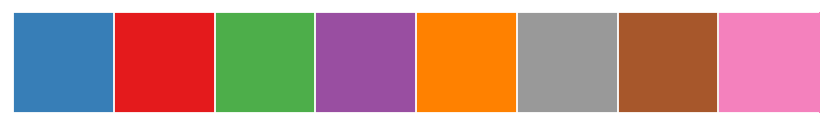

In [6]:
import matplotlib as mpl
from cycler import cycler

bmap = sns.color_palette("Set1", 9)
colors = np.array(bmap)[(1,0,2,3,4,8,6,7), :]
mpl.rcParams['axes.prop_cycle'] = cycler('color', colors)
colors_labels = ['blue', 'red', 'green', 'violet', 'orange', 'gray', 'brown', 'pink', ]
for c, cl in zip(colors, colors_labels):
    locals()[cl] = tuple(c) # assign variables with color names
sns.palplot(colors)

# Compute Burst Data

## Burst Search Parameters

In [7]:
m = 10

rate_th = 25e3
ph_sel = Ph_sel(Dex='DAem')

bg_kwargs_auto = dict(fun=bg.exp_fit,
                 time_s = 30,
                 tail_min_us = 'auto',
                 F_bg=1.7,)

samples = ('7d', '12d', '17d', '22d', '27d', 'DO')

## Multispot

### Correction Factors

Load the **leakage coefficient** from disk (computed in [Multi-spot 5-Samples analysis - Leakage coefficient - Summary](Multi-spot 5-Samples analysis - Leakage coefficient - Summary.ipynb)):

In [8]:
leakage_coeff_fname = 'results/Multi-spot - leakage coefficient KDE wmean DexDem.csv'
leakageM = np.loadtxt(leakage_coeff_fname, ndmin=1)

print('Multispot Leakage Coefficient:', leakageM)

Multispot Leakage Coefficient: [ 0.0334]


Load the **direct excitation coefficient** ($d_{dirT}$) from disk (computed in [usALEX - Corrections - Direct excitation physical parameter](usALEX - Corrections - Direct excitation physical parameter.ipynb)):

In [9]:
dir_ex_coeff_fname = 'results/usALEX - direct excitation coefficient dir_ex_t beta.csv'
dir_ex_t = np.loadtxt(dir_ex_coeff_fname, ndmin=1)

print('Direct excitation coefficient (dir_ex_t):', dir_ex_t)

Direct excitation coefficient (dir_ex_t): [ 0.04932]


In [10]:
gamma_fname = 'results/Multi-spot - gamma factor.csv'
gammaM = np.loadtxt(gamma_fname, ndmin=1)

print('Multispot Gamma Factor (gamma):', gammaM)

Multispot Gamma Factor (gamma): [ 0.45525]


### Multispot Data files

In [11]:
data_dir = './data/multispot/'
file_list = sorted(glob(data_dir + '*.hdf5'))
labels = ['7d', '12d', '17d', '22d', '27d', 'DO']
files_dict = {lab: fname for lab, fname in zip(sorted(labels), file_list)}
files_dict

{'12d': './data/multispot/12d_New_30p_320mW_steer_3.hdf5',
 '17d': './data/multispot/17d_100p_320mW_steer_1.hdf5',
 '22d': './data/multispot/22d_30p_320mW_steer_1.hdf5',
 '27d': './data/multispot/27d_50p_320mW_steer_1.hdf5',
 '7d': './data/multispot/7d_New_150p_320mW_steer_3.hdf5',
 'DO': './data/multispot/DO12_No2_50p_320mW_steer_1.hdf5'}

In [12]:
BurstsM = {}
for data_id in samples:
    dx = loader.photon_hdf5(files_dict[data_id])
    dx.calc_bg(**bg_kwargs_auto)
    dx.leakage = leakageM
    dx.burst_search(m=m, min_rate_cps=rate_th, ph_sel=ph_sel)
    
    dx.calc_max_rate(m=m, ph_sel=Ph_sel(Dex='Aem'))
    max_rate_Aem = dx.max_rate
    dx.calc_max_rate(m=m, ph_sel=Ph_sel(Dex='Dem'))
    max_rate_Dem = dx.max_rate
    dx.calc_max_rate(m=m, ph_sel=Ph_sel(Dex='DAem'))
    bursts = pd.concat([bext.burst_data(dx, ich=ich)
                        .assign(ich=ich)
                        .assign(max_rate_Dem=max_rate_Dem[ich])
                        .assign(max_rate_Aem=max_rate_Aem[ich])                        
                        for ich in range(8)])

    bursts = bursts.round({'E': 6, 'bg_d': 3, 'bg_a': 3, 'nd': 3, 'na': 3, 'nt': 3, 
                           'width_ms': 4, 'max_rate': 3, 'max_rate_Dem': 3, 'max_rate_Aem': 3})
    bursts.to_csv('results/bursts_multispot_{}_m={}_rate_th={}_ph={}.csv'.format(data_id, m, rate_th, ph_sel))
    BurstsM[data_id] = bursts

 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   [DONE Counting D/A]


## usALEX

In [13]:
leakage_coeff_fname = 'results/usALEX - leakage coefficient DexDem.csv'
leakageA = np.loadtxt(leakage_coeff_fname, ndmin=1)
print('usALEX Leakage coefficient:', leakageA)

usALEX Leakage coefficient: [ 0.10029]


In [14]:
dir_ex_coeff_aa_fname = 'results/usALEX - direct excitation coefficient dir_ex_aa.csv'
dir_ex_aa = np.loadtxt(dir_ex_coeff_aa_fname, ndmin=1)
print('usALEX Direct excitation coefficient (dir_ex_aa):', dir_ex_aa)

usALEX Direct excitation coefficient (dir_ex_aa): [ 0.06062]


In [15]:
gamma_fname = 'results/usALEX - gamma factor - all-ph.csv'
gammaA = np.loadtxt(gamma_fname, ndmin=1)
print('usALEX Gamma Factorr (gamma):', gammaA)

usALEX Gamma Factorr (gamma): [ 1.020526]


In [16]:
data_dir = './data/singlespot/'
file_list = sorted(glob(data_dir + '*.hdf5'))
labels = ['17d', '27d', '7d', '12d', '22d']
files_dict = {lab: fname for lab, fname in zip(labels, file_list)}
files_dict

{'12d': './data/singlespot/007_dsDNA_12d_3nM_green100u_red40u.hdf5',
 '17d': './data/singlespot/004_dsDNA_17d_green100u_red40u.hdf5',
 '22d': './data/singlespot/008_dsDNA_22d_500pM_green100u_red40u.hdf5',
 '27d': './data/singlespot/005_dsDNA_27d_green100u_red40u.hdf5',
 '7d': './data/singlespot/006_dsDNA_7d_green100u_red40u.hdf5'}

In [17]:
BurstsA = {}
for data_id in samples:
    if data_id not in files_dict:
        continue
    dx = loader.photon_hdf5(files_dict[data_id])
    loader.usalex_apply_period(dx)
    dx.calc_bg(**bg_kwargs_auto)
    dx.leakage = leakageA
    dx.burst_search(m=m, min_rate_cps=rate_th, ph_sel=ph_sel)
    
    dx.calc_max_rate(m=m, ph_sel=Ph_sel(Dex='Aem'), compact=True)
    max_rate_Aem = dx.max_rate
    dx.calc_max_rate(m=m, ph_sel=Ph_sel(Dex='Dem'), compact=True)
    max_rate_Dem = dx.max_rate
    dx.calc_max_rate(m=m, ph_sel=Ph_sel(Dex='DAem'), compact=True)
    bursts = (bext.burst_data(dx)
                  .assign(max_rate_Dem=max_rate_Dem[0])
                  .assign(max_rate_Aem=max_rate_Aem[0]))

    bursts = bursts.round({'E': 6, 'S': 6, 'bg_d': 3, 'bg_a': 3, 'bg_aa': 3, 'nd': 3, 'na': 3, 'naa': 3, 'nda': 3, 'nt': 3, 
                           'width_ms': 4, 'max_rate': 3, 'max_rate_Dem': 3, 'max_rate_Aem': 3})
    bursts.to_csv('results/bursts_usALEX_{}_m={}_rate_th={}_ph={}.csv'.format(data_id, m, rate_th, ph_sel))
    BurstsA[data_id] = bursts

 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


 - Calculating BG rates ... 

[DONE]


 - Performing burst search (verbose=False) ...

 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


In [18]:
Dex_fraction = bl.get_alex_fraction(dx.D_ON[0], dx.alex_period)
Dex_fraction

0.4375

In [19]:
#Dex_fraction = 0.4375  # Use this when not loading the files

# Load Data

In [20]:
import pandas as pd

In [21]:
ph_sel

Ph_sel(Dex='DAem', Aex=None)

In [22]:
BurstsM = {}
for data_id in samples:
    fname = 'results/bursts_multispot_{}_m={}_rate_th={}_ph={}.csv'.format(data_id, m, rate_th, ph_sel)
    bursts = pd.read_csv(fname, index_col=0)
    BurstsM[data_id] = bursts

In [23]:
BurstsA = {}
for data_id in samples:
    if data_id == 'DO':
        continue
    fname = 'results/bursts_usALEX_{}_m={}_rate_th={}_ph={}.csv'.format(data_id, m, rate_th, ph_sel)
    bursts = pd.read_csv(fname, index_col=0)
    BurstsA[data_id] = bursts

In [24]:
bursts.head()

,E,S,bp,max_rate,na,naa,nd,nda,nt,size_raw,t_end,t_start,width_ms,max_rate_Dem,max_rate_Aem
0,-0.015469,0.757376,0,61862.565,-0.130,2.692,8.535,-0.022,11.097,13,0.016482,0.016189,0.2930,NaN,NaN
1,0.072348,0.582521,0,417148.378,2.216,21.951,28.413,-0.073,52.580,59,0.017289,0.016290,0.9990,418083.788,NaN
2,0.281604,0.574864,0,104607.148,6.492,17.050,16.562,-0.066,40.104,45,0.017840,0.016934,0.9053,60698.762,NaN
3,0.035856,0.537769,0,142403.783,0.883,21.176,23.753,-0.058,45.812,51,0.032178,0.031393,0.7852,143339.193,NaN
4,0.077460,0.600084,0,312436.877,2.017,17.357,24.027,-0.045,43.402,48,0.156147,0.155535,0.6125,313372.287,NaN


# Correcting na 

$$Dir = d_{dirT} \, (n_a + \gamma \, n_d)$$

$$n_a = n_a^* - Lk - Dir = n_{al} - Dir = n_{al} - d_{dirT} \, (n_a + \gamma \, n_d)$$

$$(1 + d_{dirT}) \, n_a = n_{al} - d_{dirT} \gamma \, n_d$$

$$ n_a = \frac{n_{al} - d_{dirT} \gamma \, n_d}{1 + d_{dirT}}$$


In [25]:
def corr_na(nal, nd, gamma, dir_ex_t):
    return (nal - dir_ex_t * gamma * nd) / (1 + dir_ex_t)

In [26]:
# for bursts in BurstsA.values():
#     bursts['na_corr1'] = corr_na(bursts.na, bursts.nd, gammaA, dir_ex_t)

# for bursts in BurstsA.values():
#     bursts['na_corr2'] = bursts.na - dir_ex_aa*bursts.naa

# for bursts in BurstsA.values():
#     plt.figure()
#     plt.plot((bursts.na - bursts.na_corr1) - (bursts.na - bursts.na_corr2), 'o', alpha=0.2)
#     plt.ylim(-3, 3)

# Figures

In [27]:
sns.set(style='ticks', font_scale=1.4, palette=colors)

In [28]:
lw = 2.5

## Corrected burst size

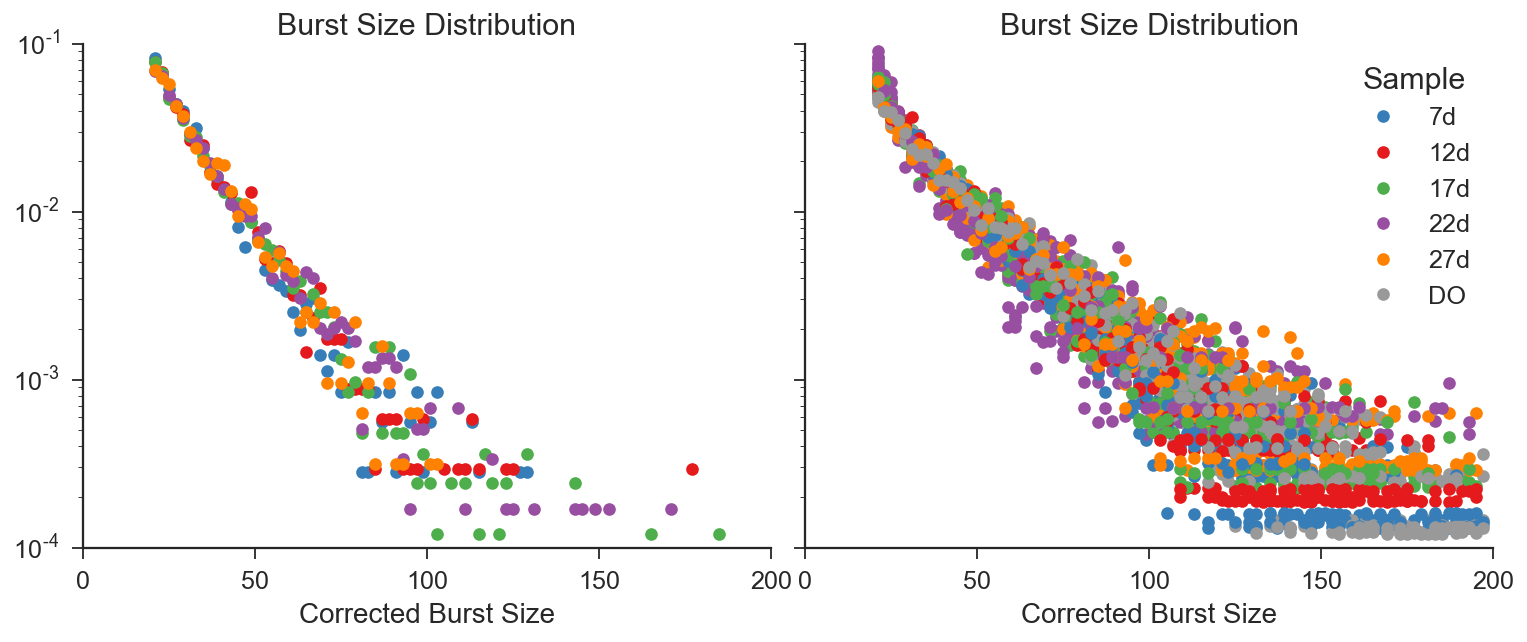

In [29]:
size_th = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
plt.subplots_adjust(wspace=0.05)

bins = np.arange(0, 200, 2)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for ich in range(8):
    for i, s in enumerate(samples[:]):
        bursts = BurstsM[s]
        color = colors[i]
        mask = bursts.ich == ich
        sizes = bursts.na[mask] + gammaM*bursts.nd[mask]
        sizes = sizes.loc[sizes > size_th]
        counts, bins = np.histogram(sizes, bins, normed=True)
        label = s if ich == 0 else ''
        ax[1].plot(x, counts, marker='o', ls='', color=color, label=label)
        
        if ich == 0 and 'DO' not in s:
            bursts = BurstsA[s]
            sizes = bursts.na + bursts.nd * gammaA
            sizes = sizes.loc[sizes > size_th]
            counts, bins = np.histogram(sizes, bins, normed=True)
            ax[0].plot(x, counts, marker='o', ls='', color=color, label=label)
        
plt.yscale('log')
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a)
    a.set_title('Burst Size Distribution')
    a.set_xlabel('Corrected Burst Size')

In [30]:
gammaA, gammaM

(array([ 1.020526]), array([ 0.45525]))

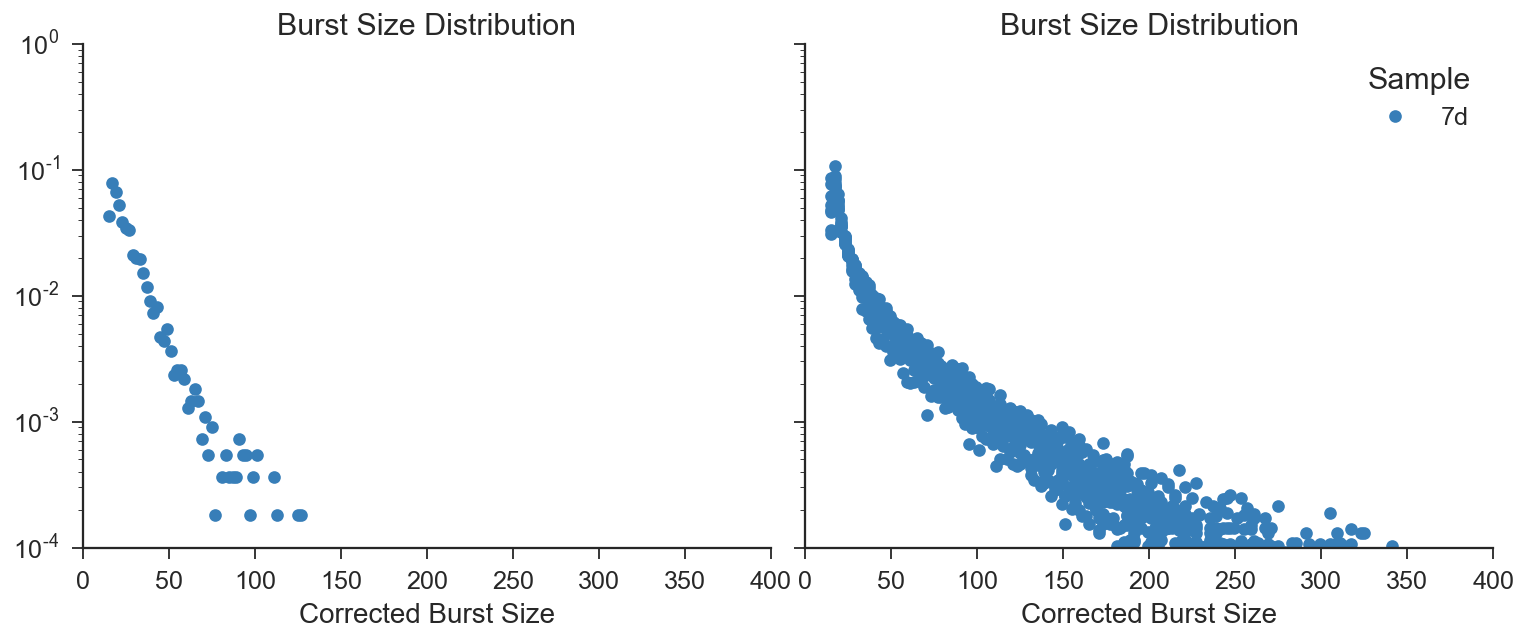

In [31]:
size_th = 15
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
plt.subplots_adjust(wspace=0.05)

bins = np.arange(0, 400, 2)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for ich in range(8):
    for i, s in enumerate(samples[:1]):
        bursts = BurstsM[s]
        color = colors[i]
        mask = bursts.ich == ich
        sizes = bursts.na[mask]/gammaM + bursts.nd[mask]
        sizes = sizes.loc[sizes > size_th]
        counts, bins = np.histogram(sizes, bins, normed=True)
        label = s if ich == 0 else ''
        ax[1].plot(x, counts, marker='o', ls='', color=color, label=label)
        
        if ich == 0 and 'DO' not in s:
            bursts = BurstsA[s]
            sizes = bursts.na/gammaA + bursts.nd
            sizes = sizes.loc[sizes > size_th]
            counts, bins = np.histogram(sizes, bins, normed=True)
            ax[0].plot(x, counts, marker='o', ls='', color=color, label=label)
        
plt.yscale('log')
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a)
    a.set_title('Burst Size Distribution')
    a.set_xlabel('Corrected Burst Size')

## Bursts Counts

### DexAem Counts

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


Saved: figures/na distribution usALEX vs multispot, size_th=15


Saved: figures/na distribution usALEX vs multispot, size_th=15.svg


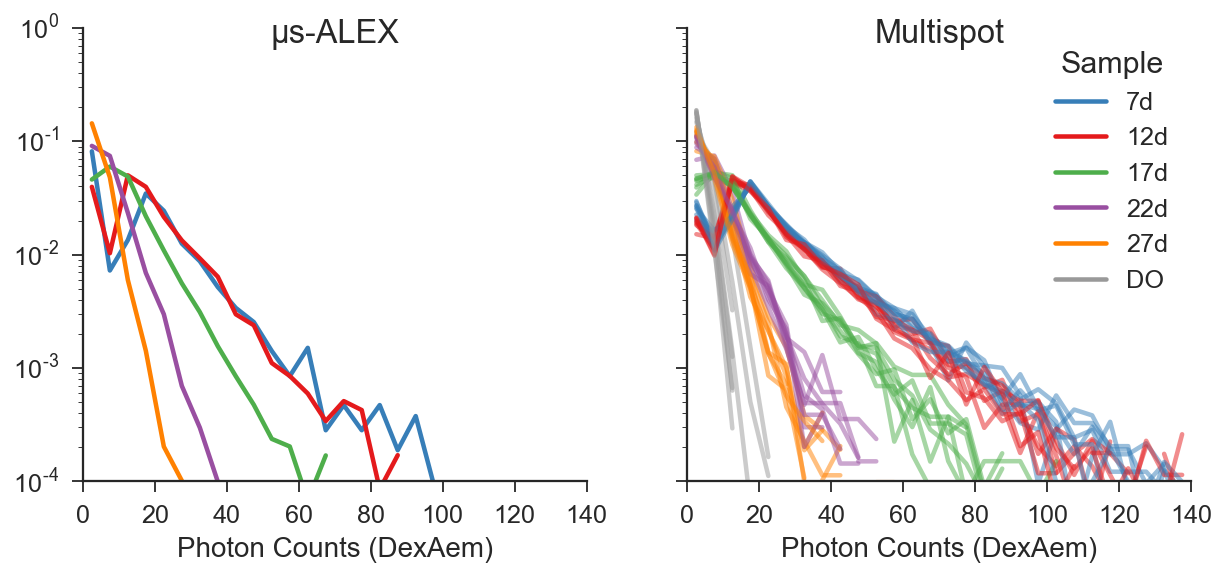

In [32]:
var = 'na'
size_th = 15
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.05)
#kws = dict(marker='o', ls='')
kws = dict(lw=lw)
var_labels = dict(na='DexAem', nd='DexDem')

bins = np.arange(0, 350, 5)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for ich in range(8):
    for i, s in enumerate(samples[:]):
        bursts = BurstsM[s]
        bursts = bursts.loc[bursts.ich == ich]
        color = colors[i]
        sizes = bursts.na + bursts.nd * gammaM
        mask = (sizes > size_th)
        data = bursts.loc[mask, var]
        counts, bins = np.histogram(data, bins, normed=True)
        if ich == 0:
            ax[1].plot([], label=s, **kws)  # empty lines for the legend
        counts[counts == 0] = np.nan        # break lines at zeros in log-scale
        ax[1].plot(x, counts, color=color, alpha=0.5, **kws)
        
        if ich == 0 and 'DO' not in s:
            bursts = BurstsA[s]
            sizes = bursts.na + bursts.nd * gammaA
            mask = (sizes > size_th)
            data = bursts.loc[mask, var]
            counts, bins = np.histogram(data, bins, normed=True)
            counts[counts == 0] = np.nan        # break lines at zeros
            ax[0].plot(x, counts, color=color, label=label, **kws)
        
plt.yscale('log')
plt.ylim(1e-4)
if var == 'na':
    plt.xlim(0, 140)
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a)
    #a.set_title('DexAem Burst Size Distribution')
    a.set_xlabel('Photon Counts (%s)' % var_labels[var])
title_kw = dict(fontdict={'verticalalignment': 'top'}, fontsize=18)
ax[0].set_title('μs-ALEX', **title_kw)
ax[1].set_title('Multispot', **title_kw);
savefig('%s distribution usALEX vs multispot, size_th=%d' % (var, size_th))
savefig('%s distribution usALEX vs multispot, size_th=%d.svg' % (var, size_th))

### DexDem Counts

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


Saved: figures/nd distribution usALEX vs multispot, size_th=15


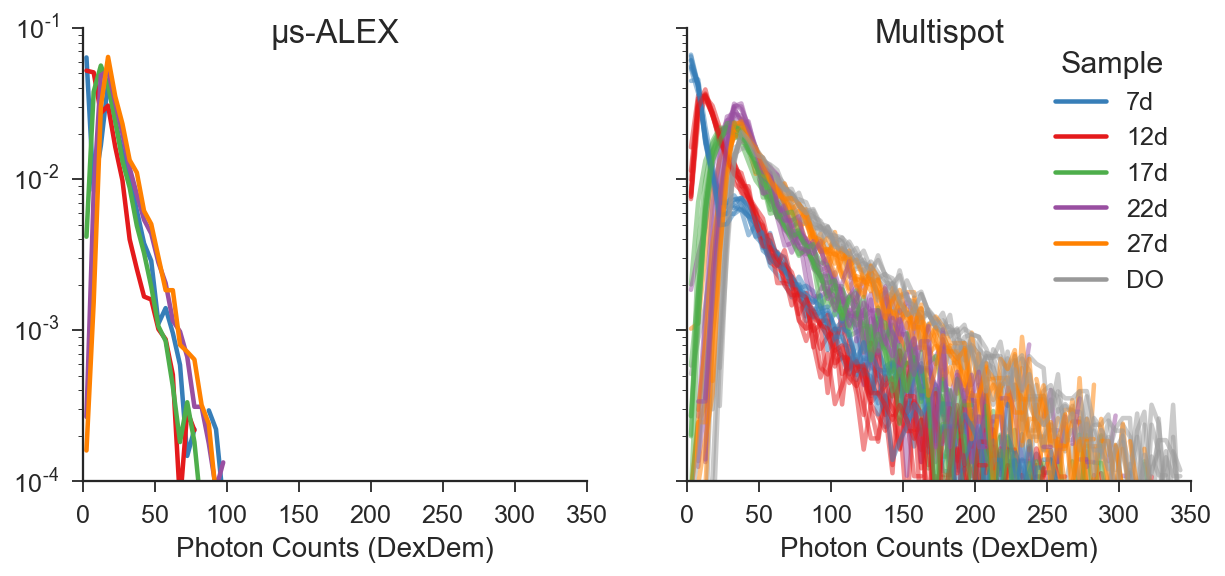

In [33]:
var = 'nd'
size_th = 15
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.05)
#kws = dict(marker='o', ls='')
kws = dict(lw=lw)
var_labels = dict(na='DexAem', nd='DexDem')

bins = np.arange(0, 350, 5)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for ich in range(8):
    for i, s in enumerate(samples[:]):
        bursts = BurstsM[s]
        bursts = bursts.loc[bursts.ich == ich]
        color = colors[i]
        sizes = bursts.na + bursts.nd * gammaM
        mask = (sizes > size_th)
        data = bursts.loc[mask, var]
        counts, bins = np.histogram(data, bins, normed=True)
        if ich == 0:
            ax[1].plot([], label=s, **kws)  # empty lines for the legend
        counts[counts == 0] = np.nan        # break lines at zeros in log-scale
        ax[1].plot(x, counts, color=color, alpha=0.5, **kws)
        
        if ich == 0 and 'DO' not in s:
            bursts = BurstsA[s]
            sizes = bursts.na + bursts.nd * gammaA
            mask = (sizes > size_th)
            data = bursts.loc[mask, var]
            counts, bins = np.histogram(data, bins, normed=True)
            counts[counts == 0] = np.nan        # break lines at zeros
            ax[0].plot(x, counts, color=color, label=label, **kws)
        
plt.yscale('log')
plt.ylim(1e-4)
if var == 'na':
    plt.xlim(0, 140)
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a)
    #a.set_title('DexAem Burst Size Distribution')
    a.set_xlabel('Photon Counts (%s)' % var_labels[var])
title_kw = dict(fontdict={'verticalalignment': 'top'}, fontsize=18)
ax[0].set_title('μs-ALEX', **title_kw)
ax[1].set_title('Multispot', **title_kw);
savefig('%s distribution usALEX vs multispot, size_th=%d' % (var, size_th))

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


Saved: figures/nt distribution usALEX vs multispot, size_th=20


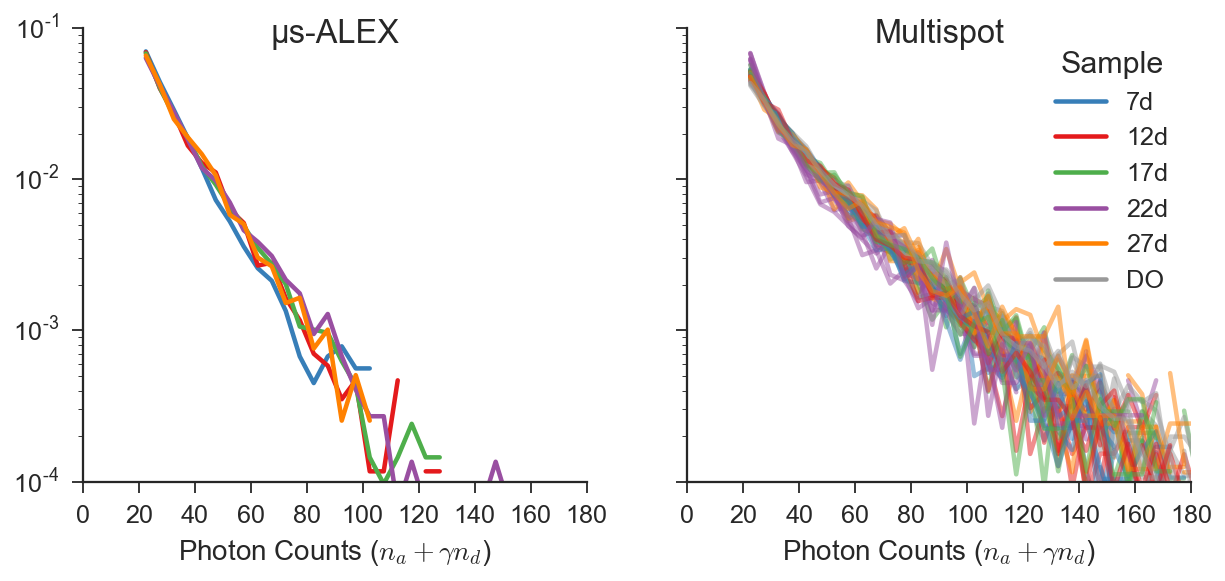

In [34]:
size_th = 20
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.05)
#kws = dict(marker='o', ls='')
kws = dict(lw=lw)

bins = np.arange(0, 200, 5)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for ich in range(8):
    for i, s in enumerate(samples[:]):
        bursts = BurstsM[s]
        bursts = bursts.loc[bursts.ich == ich]
        
        color = colors[i]
        sizes = bursts.na + bursts.nd * gammaM
        burstss = bursts.loc[sizes > size_th]
        data = burstss.na + burstss.nd * gammaM
        counts, bins = np.histogram(data, bins, normed=True)
        if ich == 0:
            ax[1].plot([], label=s, **kws)  # empty lines for the legend
        counts[counts == 0] = np.nan        # break lines at zeros
        ax[1].plot(x, counts, color=color, alpha=0.5, **kws)
        
        if ich == 0 and 'DO' not in s:
            bursts = BurstsA[s]
            sizes = bursts.na + bursts.nd * gammaA
            burstss = bursts.loc[sizes > size_th]
            data = burstss.na + burstss.nd * gammaA
            counts, bins = np.histogram(data, bins, normed=True)
            counts[counts == 0] = np.nan        # break lines at zeros
            ax[0].plot(x, counts, color=color, label=label, **kws)
        
plt.yscale('log')
plt.ylim(1e-4)
plt.xlim(0, 180)
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a)
    #a.set_title('DexAem Burst Size Distribution')
    a.set_xlabel('Photon Counts ($n_a + \gamma n_d$)')
title_kw = dict(fontdict={'verticalalignment': 'top'}, fontsize=18)
ax[0].set_title('μs-ALEX', **title_kw)
ax[1].set_title('Multispot', **title_kw);
savefig('nt distribution usALEX vs multispot, size_th=%d' % size_th)

## Bursts Counts (8-spot mean)

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


Saved: figures/na distribution usALEX vs multispot mean, size_th=15


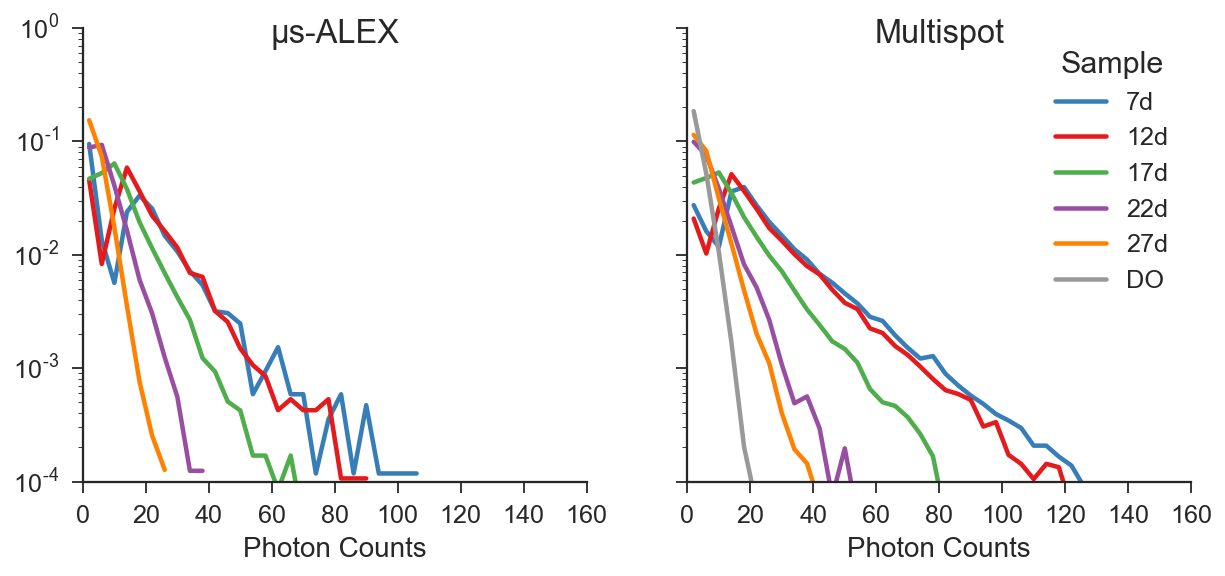

In [35]:
var = 'na'
size_th = 15
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.05)
#kws = dict(marker='o', ls='')
kws = dict(lw=lw)

bins = np.arange(0, 150, 4)
x = bins[:-1] + 0.5*(bins[1] - bins[0])

for i, s in enumerate(samples[:]):
        bursts = BurstsM[s]
        #bursts = bursts.loc[bursts.ich == ich]
        
        color = colors[i]
        sizes = bursts.na + bursts.nd * gammaM
        data = bursts.loc[sizes > size_th, var]
        counts, bins = np.histogram(data, bins, normed=True)
        label = s# if ich == 0 else ''
        counts[counts == 0] = np.nan
        ax[1].plot(x, counts, color=color, label=label, **kws)
        
        if 'DO' not in s:
            bursts = BurstsA[s]
            sizes = bursts.na + bursts.nd * gammaA
            data = bursts.loc[sizes > size_th, var]
            counts, bins = np.histogram(data, bins, normed=True)
            counts[counts == 0] = np.nan
            ax[0].plot(x, counts, color=color, label=label, **kws)
        
plt.yscale('log')
plt.ylim(1e-4)
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a)
    #a.set_title('DexAem Burst Size Distribution')
    a.set_xlabel('Photon Counts')
title_kw = dict(fontdict={'verticalalignment': 'top'}, fontsize=18)
ax[0].set_title('μs-ALEX', **title_kw)
ax[1].set_title('Multispot', **title_kw);
savefig('%s distribution usALEX vs multispot mean, size_th=%d' % (var, size_th))

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


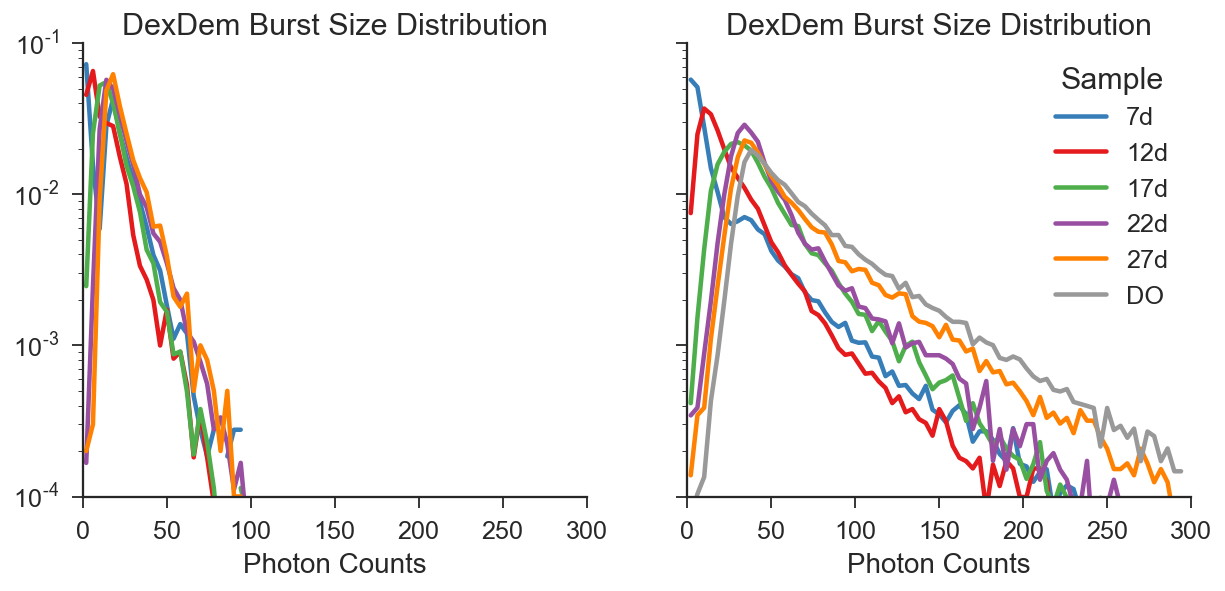

In [36]:
size_th = 15
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.05)
#kws = dict(marker='o', ls='')
kws = dict(lw=lw)

bins = np.arange(0, 300, 4)
x = bins[:-1] + 0.5*(bins[1] - bins[0])

for i, s in enumerate(samples[:]):
        bursts = BurstsM[s]
        #bursts = bursts.loc[bursts.ich == ich]
        
        color = colors[i]
        sizes = bursts.na + bursts.nd * gammaM
        data = bursts.loc[sizes > size_th, 'nd']
        counts, bins = np.histogram(data, bins, normed=True)
        label = s# if ich == 0 else ''
        counts[counts == 0] = np.nan
        ax[1].plot(x, counts, color=color, label=label, **kws)
        
        if 'DO' not in s:
            bursts = BurstsA[s]
            sizes = bursts.na + bursts.nd * gammaA
            data = bursts.nd.loc[sizes > size_th]
            counts, bins = np.histogram(data, bins, normed=True)
            counts[counts == 0] = np.nan
            ax[0].plot(x, counts, color=color, label=label, **kws)
        
plt.yscale('log')
plt.ylim(1e-4)
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a, trim=True)
    a.set_title('DexDem Burst Size Distribution')
    a.set_xlabel('Photon Counts')

## Burst duration

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


Saved: figures/width_ms distribution usALEX vs multispot, size_th=15


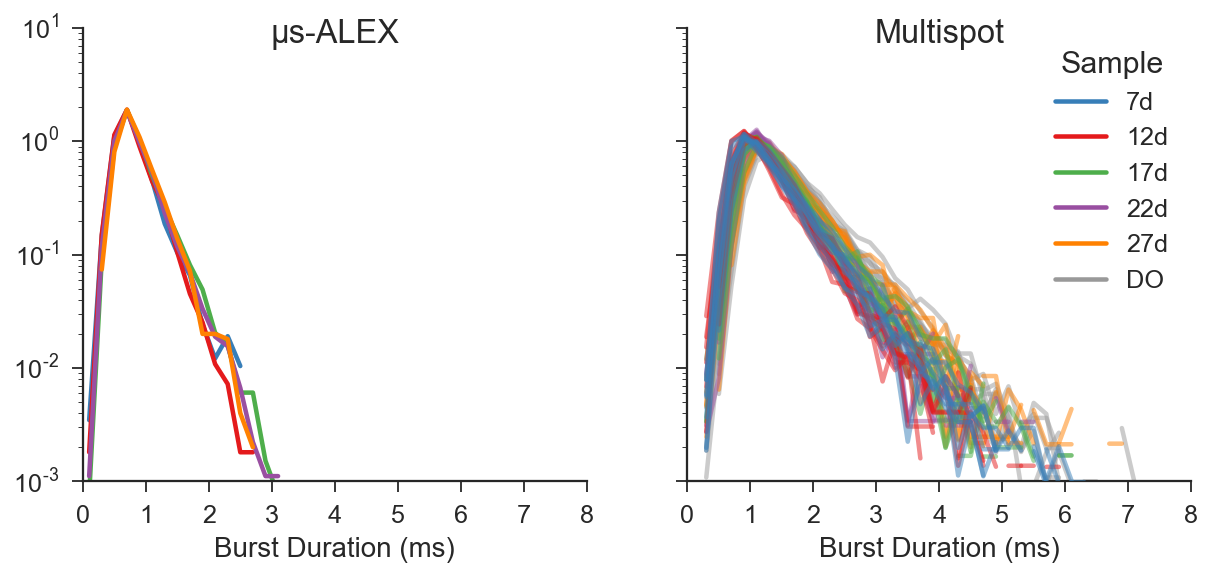

In [37]:
var = 'width_ms'
size_th = 15

fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.05)
kws = dict(lw=lw)
bins = np.arange(0, 8, 0.2)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for i, s in enumerate(samples[:]):
    for ich in range(8):
        bursts = BurstsM[s]
        color = colors[i]
        burstsc = bursts.loc[bursts.ich == ich]
        sizes = burstsc.na + burstsc.nd * gammaM
        widths = burstsc.loc[sizes > size_th, var]
        counts, bins = np.histogram(widths, bins, normed=True)
        #label = s if ich == 0 else ''
        if ich == 0:
            ax[1].plot([], label=s, **kws)  # empty lines for the legend
        counts[counts == 0] = np.nan        # break lines at zeros
        ax[1].plot(x, counts, color=color, alpha=0.5, 
                   zorder=5-i, **kws)
        
        if ich == 0 and 'DO' not in s:
            bursts = BurstsA[s]
            sizes = bursts.na + bursts.nd * gammaA
            widths = bursts.loc[sizes > size_th, var]
            counts, bins = np.histogram(widths, bins, normed=True)
            counts[counts == 0] = np.nan        # break lines at zeros
            ax[0].plot(x, counts, color=color, label=label, **kws)
        
plt.yscale('log')
plt.ylim(1e-3)
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a, trim=True)
    #a.set_title('Burst Duration Distribution')
    a.set_xlabel('Burst Duration (ms)')
title_kw = dict(fontdict={'verticalalignment': 'top'}, fontsize=18)
ax[0].set_title('μs-ALEX', **title_kw)
ax[1].set_title('Multispot', **title_kw);
savefig('%s distribution usALEX vs multispot, size_th=%d' % (var, size_th))

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


Saved: figures/width_ms distribution usALEX vs multispot mean, size_th=15


Saved: figures/width_ms distribution usALEX vs multispot mean, size_th=15.svg


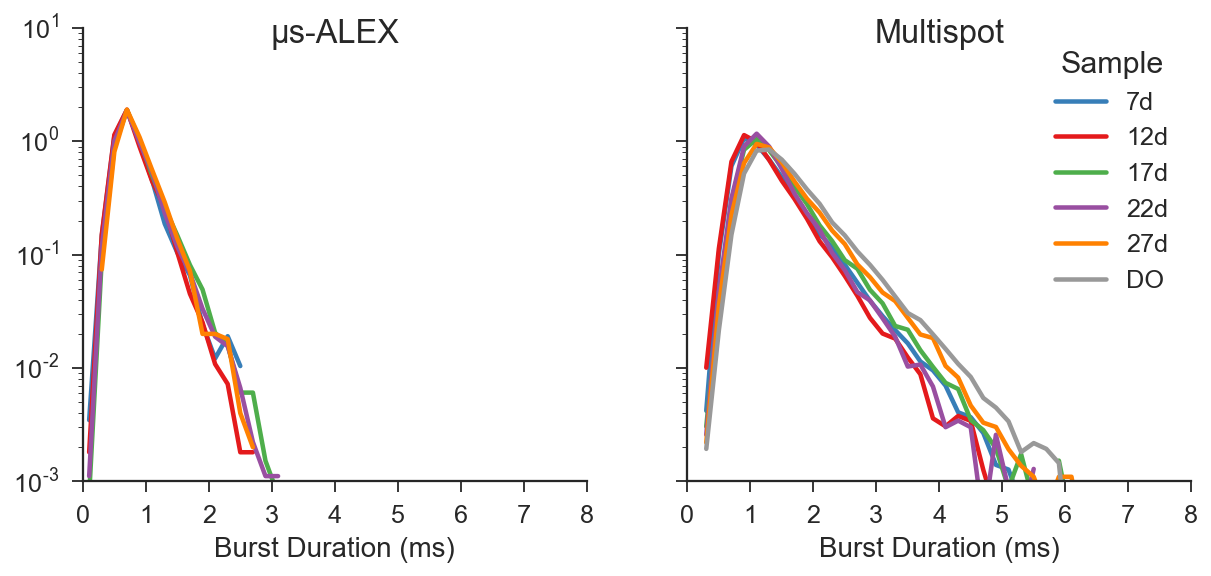

In [38]:
var = 'width_ms'
size_th = 15

fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.05)
kws = dict(lw=lw)
bins = np.arange(0, 8, 0.2)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for i, s in enumerate(samples[:]):
        bursts = BurstsM[s]
        color = colors[i]
    
        sizes = bursts.na + bursts.nd * gammaM
        widths = bursts.loc[sizes > size_th, var]
        counts, bins = np.histogram(widths, bins, normed=True)
        counts[counts == 0] = np.nan        # break lines at zeros
        ax[1].plot(x, counts, color=color, label=s, **kws)
        
        if 'DO' not in s:
            bursts = BurstsA[s]
            sizes = bursts.na + bursts.nd * gammaA
            widths = bursts.loc[sizes > size_th, var]
            counts, bins = np.histogram(widths, bins, normed=True)
            counts[counts == 0] = np.nan        # break lines at zeros
            ax[0].plot(x, counts, color=color, label=label, **kws)
        
plt.yscale('log')
plt.ylim(1e-3)
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a, trim=True)
    #a.set_title('Burst Duration Distribution')
    a.set_xlabel('Burst Duration (ms)')
title_kw = dict(fontdict={'verticalalignment': 'top'}, fontsize=18)
ax[0].set_title('μs-ALEX', **title_kw)
ax[1].set_title('Multispot', **title_kw);
savefig('%s distribution usALEX vs multispot mean, size_th=%d' % (var, size_th))
savefig('%s distribution usALEX vs multispot mean, size_th=%d.svg' % (var, size_th))

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


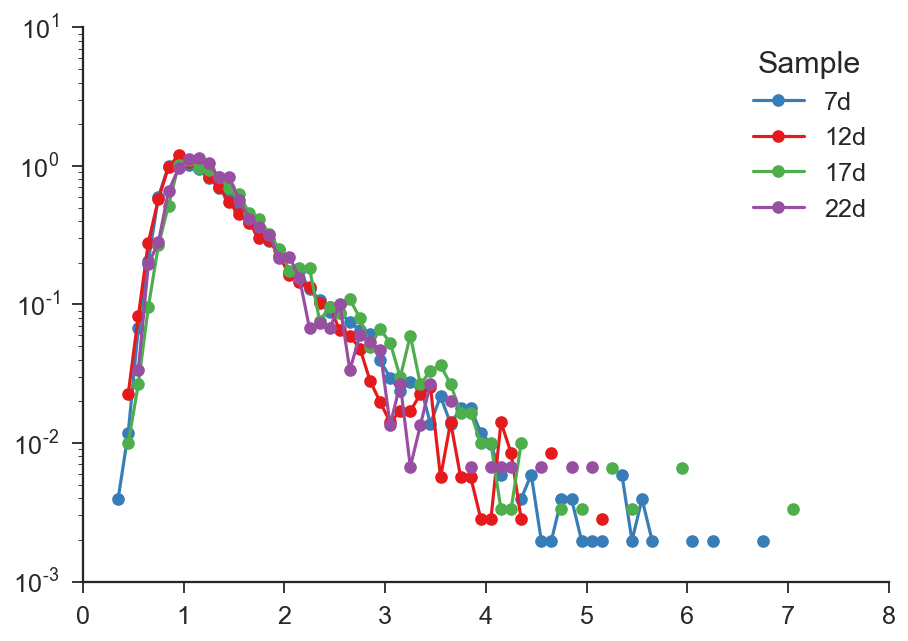

In [39]:
bins = np.arange(0, 8, 0.1)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for ich in [5]:
    for i, s in enumerate(samples[:4]):
        bursts = BurstsM[s]
        bursts = bursts.loc[bursts.ich == ich]
        
        #color = colors[ich]
        sizes = bursts.na + bursts.nd * gammaM
        burstsm = bursts.loc[sizes > size_th]
        counts, bins = np.histogram(burstsm.width_ms, bins=bins, normed=True)
        label = s #if ich == 0 else ''
        counts[counts == 0] = np.nan        # break lines at zeros in log-scale
        plt.plot(x, counts, marker='o', ls='-', alpha=1, label=label)
plt.yscale('log')
plt.legend(title='Sample')
sns.despine()

> **NOTE**: No effect of reduced diffusion time in 22d sample is visible. FCS shows a 25% reduction instead.

## Peak photon rate, donor-ref

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


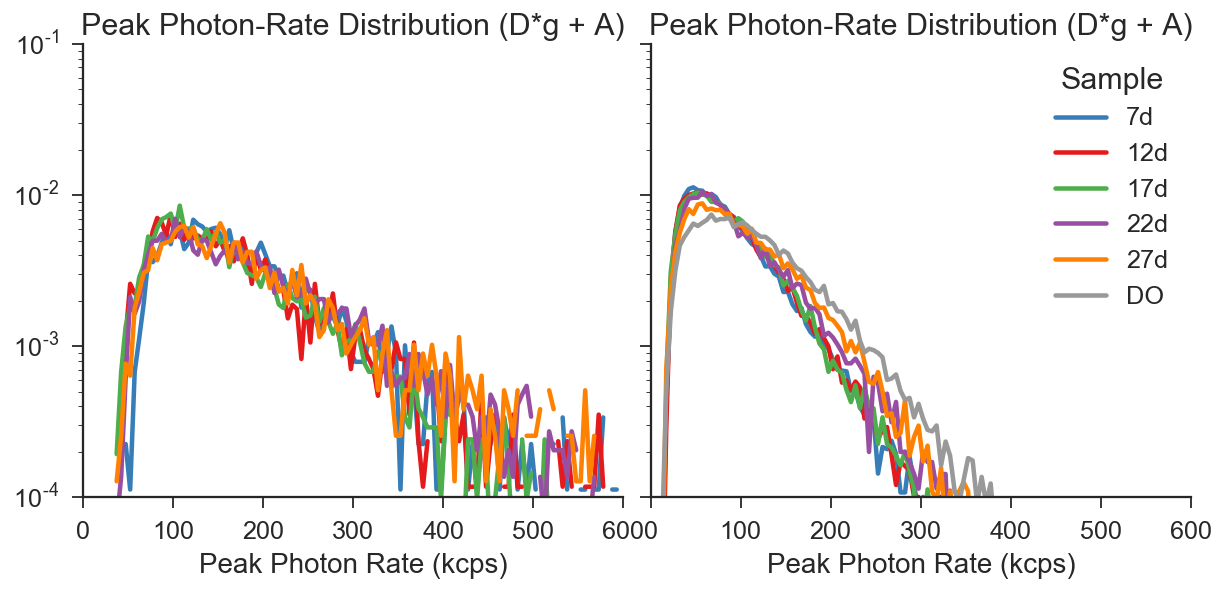

In [40]:
size_th = 20
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05)
kws = dict(lw=lw)

bins = np.arange(0, 600, 5)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for i, s in enumerate(samples[:]):
        bursts = BurstsM[s].fillna(0)
        color = colors[i]
        
        sizes = bursts.na + bursts.nd * gammaM
        burstsm = bursts.loc[sizes > size_th]
        max_rates = burstsm.max_rate_Aem + burstsm.max_rate_Dem * gammaM
        counts, bins = np.histogram(max_rates*1e-3, bins=bins, normed=True)
        label = s# if ich == 0 else ''
        counts[counts == 0] = np.nan        # break lines at zeros
        ax[1].plot(x, counts, alpha=1, color=color, label=label, **kws)
        
        if 'DO' not in s:
            bursts = BurstsA[s].fillna(0)
            sizes = bursts.na + bursts.nd * gammaA
            burstsm = bursts.loc[sizes > size_th]
            max_rates = burstsm.max_rate_Aem + burstsm.max_rate_Dem * gammaA
            counts, bins = np.histogram(max_rates*1e-3, bins=bins, normed=True)
            counts[counts == 0] = np.nan        # break lines at zeros
            ax[0].plot(x, counts, color=color, label=s, **kws)
        
plt.yscale('log')
plt.ylim(1e-4)
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a, trim=True)
    a.set_title('Peak Photon-Rate Distribution (D*g + A)')
    a.set_xlabel('Peak Photon Rate (kcps)')

## Peak photon rate, acceptor-ref

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


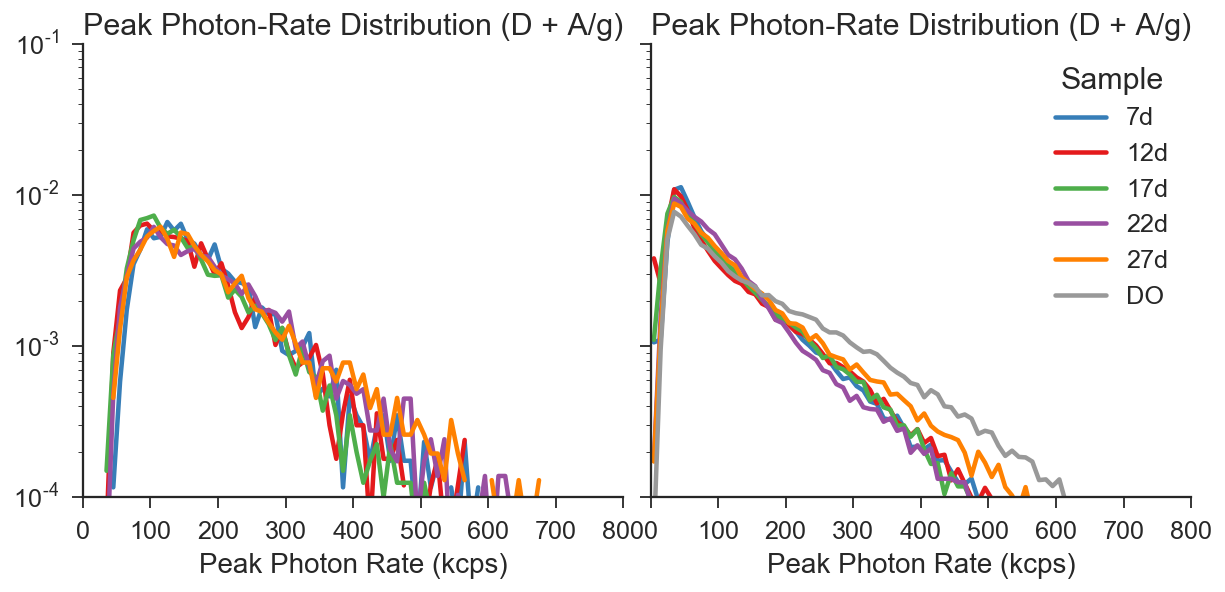

In [41]:
size_th = 20
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05)
kws = dict(lw=lw)

bins = np.arange(0, 800, 10)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for i, s in enumerate(samples[:]):
        bursts = BurstsM[s].fillna(0)
        color = colors[i]
        
        sizes = bursts.na/gammaM + bursts.nd
        burstsm = bursts.loc[sizes > size_th]
        max_rates = burstsm.max_rate_Aem/gammaM + burstsm.max_rate_Dem 
        counts, bins = np.histogram(max_rates*1e-3, bins=bins, normed=True)
        label = s# if ich == 0 else ''
        counts[counts == 0] = np.nan        # break lines at zeros
        ax[1].plot(x, counts, color=color, label=label, **kws)
        
        if 'DO' not in s:
            bursts = BurstsA[s].fillna(0)
            sizes = bursts.na/gammaA + bursts.nd
            burstsm = bursts.loc[sizes > size_th]
            max_rates = burstsm.max_rate_Aem/gammaA + burstsm.max_rate_Dem
            counts, bins = np.histogram(max_rates*1e-3, bins=bins, normed=True)
            counts[counts == 0] = np.nan        # break lines at zeros
            ax[0].plot(x, counts, color=color, label=s, **kws)
        
plt.yscale('log')
plt.ylim(1e-4)
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a, trim=True)
    a.set_title('Peak Photon-Rate Distribution (D + A/g)')
    a.set_xlabel('Peak Photon Rate (kcps)')

## Peak photon rate Aem

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


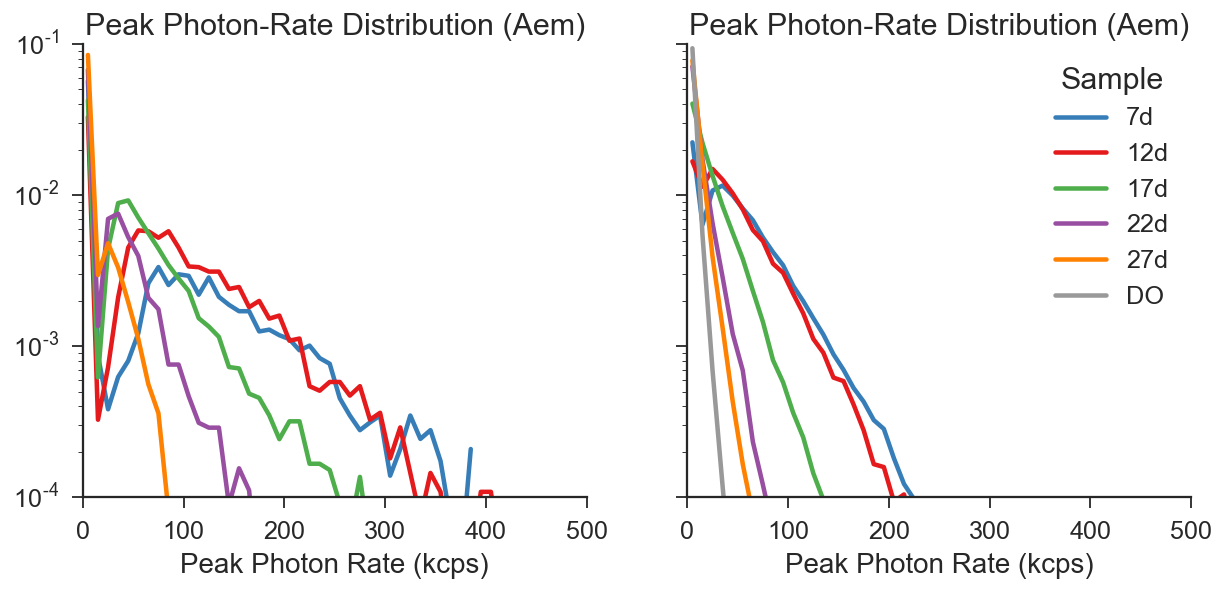

In [42]:
var = 'max_rate_Aem'
size_th = 15

fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.05)
kws = dict(lw=lw)
bins = np.arange(0, 500, 10)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for i, s in enumerate(samples[:]):
        bursts = BurstsM[s].fillna(0)
        color = colors[i]
        
        sizes = bursts.na + bursts.nd * gammaM
        burstsm = bursts.loc[sizes > size_th]
        max_rates = burstsm.max_rate_Aem
        counts, bins = np.histogram(max_rates*1e-3, bins=bins, normed=True)
        counts[counts == 0] = np.nan        # break lines at zeros
        label = s# if ich == 0 else ''
        ax[1].plot(x, counts, color=color, label=label, **kws)
        
        if 'DO' not in s:
            bursts = BurstsA[s].fillna(0)
            sizes = bursts.na + bursts.nd * gammaA
            burstsm = bursts.loc[sizes > size_th]
            max_rates = burstsm.max_rate_Aem
            counts, bins = np.histogram(max_rates*1e-3, bins=bins, normed=True)
            counts[counts == 0] = np.nan        # break lines at zeros
            ax[0].plot(x, counts, color=color, label=s, **kws)
        
plt.yscale('log')
plt.ylim(1e-4)
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a, trim=True)
    a.set_title('Peak Photon-Rate Distribution (Aem)')
    a.set_xlabel('Peak Photon Rate (kcps)')

In [43]:
Dex_fraction

0.4375

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


Saved: figures/max_rate_Aem distribution usALEX vs multispot, size_th=15


Saved: figures/max_rate_Aem distribution usALEX vs multispot, size_th=15.svg


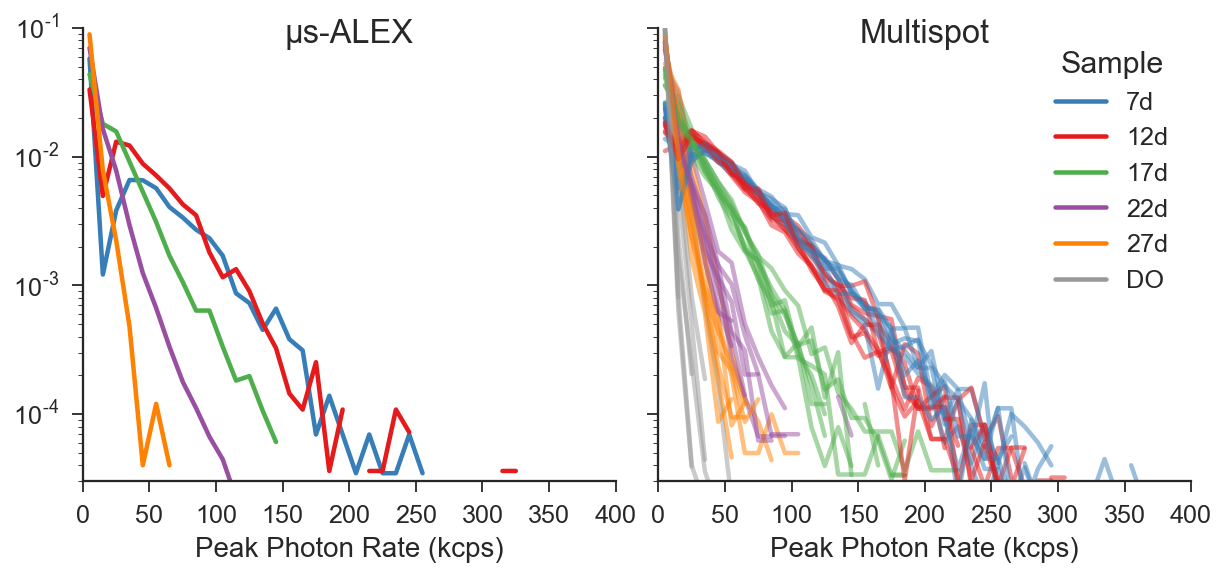

In [44]:
var = 'max_rate_Aem'
size_th = 15

fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.08)
kws = dict(lw=lw)

bins = np.arange(0, 400, 10)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for ich in range(8):
    for i, s in enumerate(samples[:]):
        bursts = BurstsM[s].fillna(0)
        bursts = bursts.loc[bursts.ich == ich]
        color = colors[i]
        
        sizes = bursts.na + bursts.nd * gammaM
        mask = (sizes > size_th)
        data = bursts.loc[mask, var] * 1e-3
        counts, bins = np.histogram(data, bins=bins, normed=True)
        counts[counts == 0] = np.nan        # break lines at zeros
        if ich == 0:
            ax[1].plot([], label=s, **kws)  # empty lines for the legend
        counts[counts == 0] = np.nan        # break lines at zeros in log-scale
        ax[1].plot(x, counts, color=color, alpha=0.5, **kws)
        
        if ich == 0 and 'DO' not in s:
            bursts = BurstsA[s].fillna(0)
            sizes = bursts.na + bursts.nd * gammaA
            mask = (sizes > size_th)
            data = bursts.loc[mask, var] * 1e-3 * Dex_fraction
            counts, bins = np.histogram(data, bins=bins, normed=True)
            counts[counts == 0] = np.nan        # break lines at zeros
            ax[0].plot(x, counts, color=color, label=s, **kws)
        
plt.yscale('log')
plt.ylim(3e-5)
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a)
    #a.set_title('Peak Photon-Rate Distribution (Aem)')
    a.set_xlabel('Peak Photon Rate (kcps)')
title_kw = dict(fontdict={'verticalalignment': 'top'}, fontsize=18)
ax[0].set_title('μs-ALEX', **title_kw)
ax[1].set_title('Multispot', **title_kw);
savefig('%s distribution usALEX vs multispot, size_th=%d' % (var, size_th))
savefig('%s distribution usALEX vs multispot, size_th=%d.svg' % (var, size_th))

> **NOTE**: The usALEX peak rates are computed removing the alternation gaps.
> Therefore the rates estimated are the ones that would be reached with a CW 
> Dex, therefore with a higher mean excitation power. Therefore to make the
> usALEX rates comparable with the multispot ones we need to mutliply the former
> by Dex_fraction (i.e. ~2).
>
> We observe that the multispot rates on the acceptor channel are ~ 20% larger
> than in the usALEX case.

/Users/anto/miniconda3/envs/multispot_paper/lib/python3.5/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


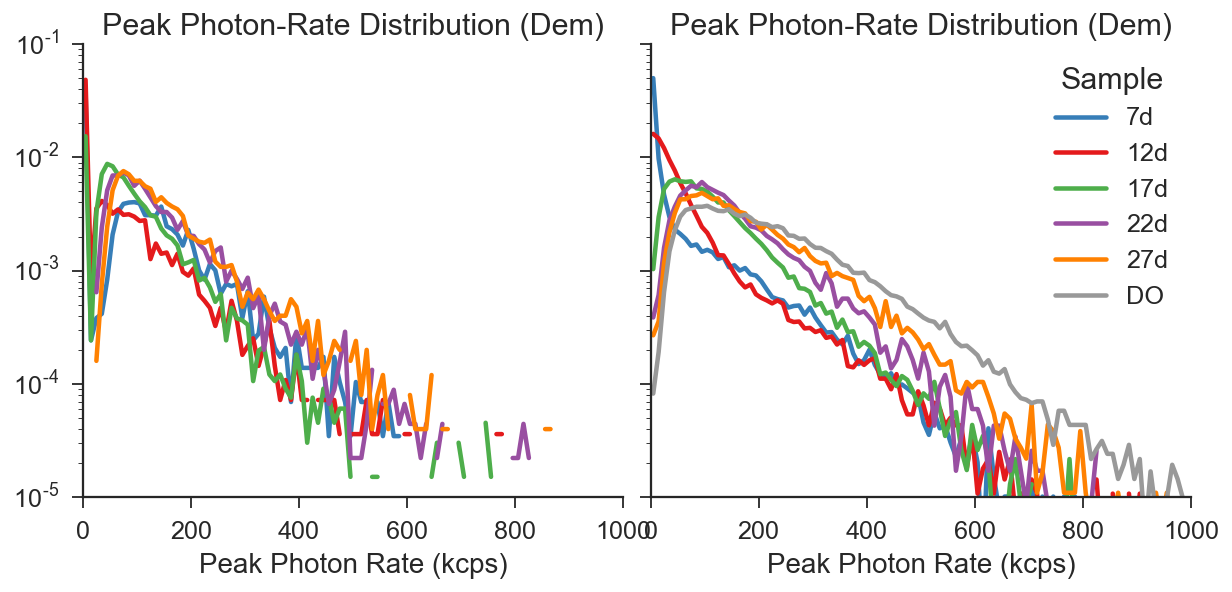

In [45]:
size_th = 15
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.05)
kws = dict(lw=lw)

bins = np.arange(0, 1000, 10)
x = bins[:-1] + 0.5*(bins[1] - bins[0])
for i, s in enumerate(samples[:]):
        bursts = BurstsM[s].fillna(0)
        color = colors[i]
        
        sizes = bursts.na + bursts.nd * gammaM
        burstsm = bursts.loc[sizes > size_th]
        max_rates = burstsm.max_rate_Dem
        counts, bins = np.histogram(max_rates*1e-3, bins=bins, normed=True)
        counts[counts == 0] = np.nan        # break lines at zeros
        label = s# if ich == 0 else ''
        ax[1].plot(x, counts, color=color, label=label, **kws)
        
        if 'DO' not in s:
            bursts = BurstsA[s].fillna(0)
            sizes = bursts.na + bursts.nd * gammaA
            burstsm = bursts.loc[sizes > size_th]
            max_rates = burstsm.max_rate_Dem
            counts, bins = np.histogram(max_rates*1e-3, bins=bins, normed=True)
            counts[counts == 0] = np.nan        # break lines at zeros
            ax[0].plot(x, counts, color=color, label=s, **kws)
        
plt.yscale('log')
ax[1].legend(title='Sample')
for a in ax:
    sns.despine(ax=a, trim=True)
    a.set_title('Peak Photon-Rate Distribution (Dem)')
    a.set_xlabel('Peak Photon Rate (kcps)')

In [46]:
def gauss(x, sig):
    return np.exp(-0.5 * (x/sig)**2)

In [47]:
box = dict(facecolor='y', alpha=0.2, pad=10)

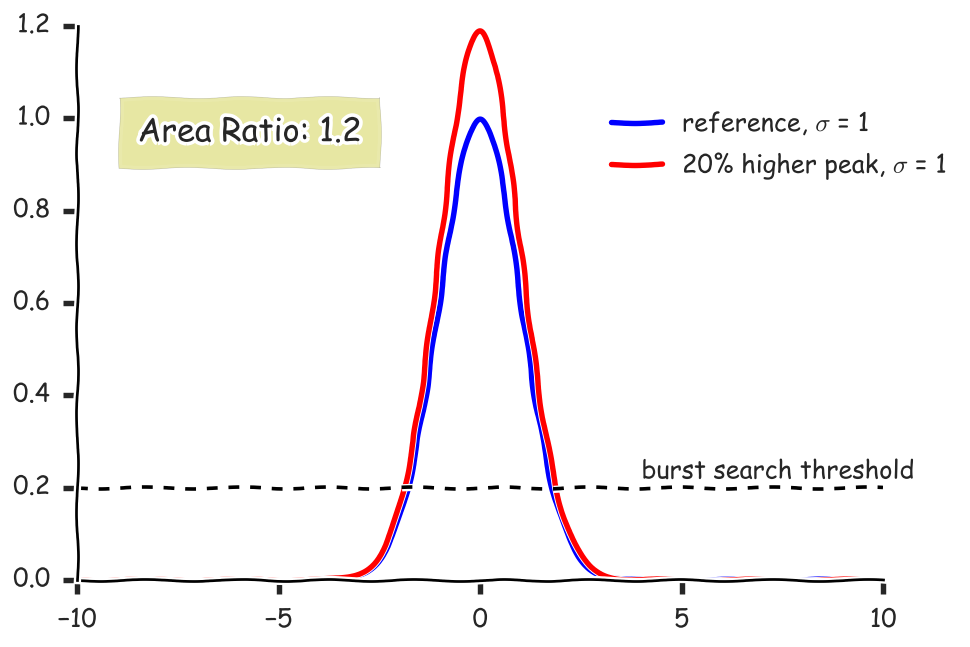

In [48]:
x = np.arange(-10, 10, 0.01)
y = gauss(x, 1)
y2 = 1.19 * gauss(x, 1)

with plt.xkcd():
    plt.plot(x, y, lw=3, label='reference, $\sigma$ = 1')
    plt.plot(x, y2, lw=3, label='20% higher peak, $\sigma$ = 1')
    plt.axhline(0.2, lw=2, ls='--', color='k')
    plt.text(4, 0.22, 'burst search threshold')
    sns.despine()
    plt.legend(loc=(0.65, 0.7))
    plt.text(-8.5, 0.95, 'Area Ratio: %.1f' % 1.2, bbox=box, fontsize=18)

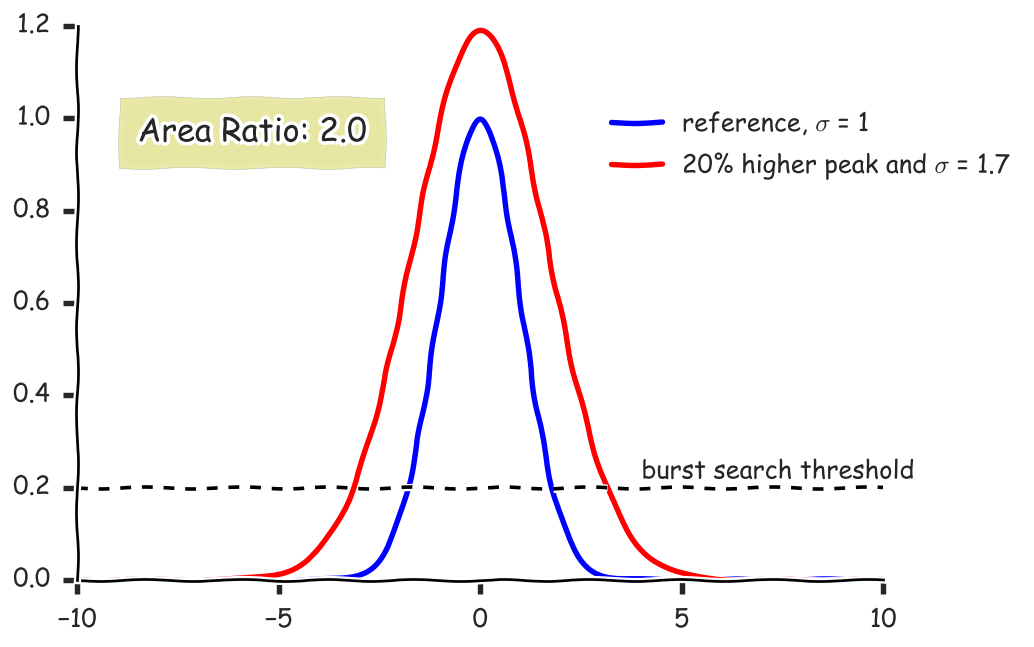

In [49]:
x = np.arange(-10, 10, 0.01)
y = gauss(x, 1)
y3 = 1.19 * gauss(x, 5/3)

with plt.xkcd():
    plt.plot(x, y, lw=3, label='reference, $\sigma$ = 1')
    plt.plot(x, y3, lw=3, label='20%% higher peak and $\sigma$ = %.1f' % (5/3))
    plt.axhline(0.2, lw=2, ls='--', color='k')
    plt.text(4, 0.22, 'burst search threshold')
    sns.despine()
    plt.legend(loc=(0.65, 0.7))
    plt.text(-8.5, 0.95, 'Area Ratio: %.1f' % (1.2 * (5/3)), bbox=box, fontsize=18)